In [1]:
import os
import json
import time
import urllib

import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

from functools import partial
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from codes.gpt_model import GPTModel
from codes.utils import generate, text_to_token_ids, token_ids_to_text
from codes.solver import train_model_simple
from codes.losses import calc_loss_loader

from codes.configs import gpt2_small_config

In [3]:
def format_input(entry):
    instruction_text = (
        f"Bellow is an instruction that describe a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input: \n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.encoded_texts)

In [4]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max([len(item)+1 for item in batch])

    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()

        new_item += [pad_token_id]

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask =  targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()

        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [5]:
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")

        with open(file_path, "w", encoding="utf-8") as fout:
            fout.write(text_data)
    #else:
    #    with open(file_path, "r", encoding="utf-8") as fin:
    #        text_data = fin.read()

    with open(file_path, "r") as fin:
        data = json.load(fin)

    return data

file_path = "ch07/instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
data = download_and_load_file(file_path, url)
print(len(data))

1100


In [6]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print(f"Training data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Validation data: {len(val_data)}")

Training data: 935
Test data: 110
Validation data: 55


In [7]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cpu")

In [8]:
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [9]:
BASE_CONFIG = gpt2_small_config()
print(BASE_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'num_heads': 12, 'n_layers': 12, 'drop_rate': 0.0, 'qkv_bias': True}


In [10]:
gpt = GPTModel(BASE_CONFIG)

pretrained_state = torch.load("./ch05/gpt2-small-124m-pretrained.pth", map_location="cpu")
gpt.load_state_dict(pretrained_state)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trans_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiheadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiheadAttention(
        (W_query): Linear(in_featu

In [11]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)

print(f"Training loss: {train_loss:.2f}")
print(f"Validation loss: {val_loss:.2f}")

Training loss: 4.57
Validation loss: 4.42


In [12]:
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2

start_time = time.time()
train_losses, val_losses, token_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
running_time_minutes = (time.time() - start_time) / 60
print(f"Training completed in {running_time_minutes:.2f} minutes.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ep 1 (Step 000000): Train loss 3.489 Val loss 3.433
Ep 1 (Step 000005): Train loss 1.943 Val loss 1.826
Ep 1 (Step 000010): Train loss 1.111 Val loss 1.193
Ep 1 (Step 000015): Train loss 1.069 Val loss 1.088
Ep 1 (Step 000020): Train loss 0.964 Val loss 1.036
Ep 1 (Step 000025): Train loss 0.911 Val loss 0.997
Ep 1 (Step 000030): Train loss 0.940 Val loss 0.966
Ep 1 (Step 000035): Train loss 0.853 Val loss 0.935
Ep 1 (Step 000040): Train loss 0.825 Val loss 0.916
Ep 1 (Step 000045): Train loss 0.747 Val loss 0.899
Ep 1 (Step 000050): Train loss 0.845 Val loss 0.893
Ep 1 (Step 000055): Train loss 0.907 Val loss 0.878
Ep 1 (Step 000060): Train loss 0.853 Val loss 0.863
Ep 1 (Step 000065): Train loss 0.774 Val loss 0.850
Ep 1 (Step 000070): Train loss 0.677 Val loss 0.840
Ep 1 (Step 000075): Train loss 0.688 Val loss 0.834
Ep 1 (Step 000080): Train loss 0.733 Val loss 0.824
Ep 1 (Step 000085): Train loss 0.667 Val loss 0.815
Ep 1 (Step 000090): Train loss 0.711 Val loss 0.806
Ep 1 (Step 0

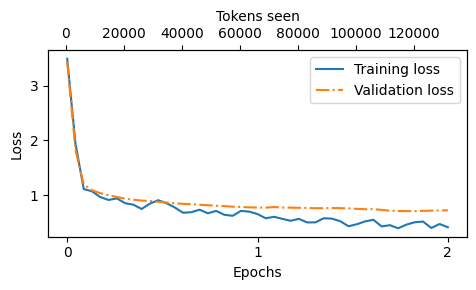

In [13]:
from codes.plots import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

In [15]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)

    token_ids = generate(
        gpt,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG['context_length'],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")

Bellow is an instruction that describe a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input: 
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a horse.<|endoftext|>The following is an excerpt from the book 'The Great Gatsby': The Story of the Great Gatsby.

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby<|endoftext|>The following is an excerpt from 'The Great Gatsby': The Story of the Great Gatsby'.

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great Gatsby

The Great